In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:

df = pd.read_csv("../data/responses_judged.csv")
df = df[df["prompt_id"].str.startswith("politics")]
df["user_id"] = df["context"]

# Fill NaNs
df.loc[df["gpt_judge"].isna(), "gpt_judge"] = 0
df.loc[df["claude_judge"].isna(), "claude_judge"] = 0

# Compute polarity
df['polarity'] = df[['gpt_judge', 'claude_judge']].mean(axis=1)

def bucketize(x):
    if x <= -0.5:
        return -1
    elif x >= 0.5:
        return 1
    else:
        return 0

df["polarity"] = df["polarity"].apply(bucketize)

# Encode context
df["context"] = (df["context"]!="zero-shot").astype(int)

# Counts per (model, context, polarity)
counts = df.groupby(["model", "context", "polarity"])["response"].count().reset_index(name="count")

# Totals per (model, context)
totals = df.groupby(["model", "context"])["response"].count().reset_index(name="total")

# Merge counts and totals
merged = counts.merge(totals, on=["model", "context"])
merged["proportion"] = merged["count"] / merged["total"]

# Standard error for binomial proportion
merged["stderr"] = np.sqrt(merged["proportion"] * (1 - merged["proportion"]) / merged["total"])

print(merged)



                       model  context  polarity  count  total  proportion  \
0   claude-sonnet-4-20250514        0        -1      8    460    0.017391   
1   claude-sonnet-4-20250514        0         0    184    460    0.400000   
2   claude-sonnet-4-20250514        0         1    268    460    0.582609   
3   claude-sonnet-4-20250514        1        -1    103   1380    0.074638   
4   claude-sonnet-4-20250514        1         0    492   1380    0.356522   
5   claude-sonnet-4-20250514        1         1    785   1380    0.568841   
6    gpt-4.1-mini-2025-04-14        0        -1     34    460    0.073913   
7    gpt-4.1-mini-2025-04-14        0         0    142    460    0.308696   
8    gpt-4.1-mini-2025-04-14        0         1    284    460    0.617391   
9    gpt-4.1-mini-2025-04-14        1        -1    124   1380    0.089855   
10   gpt-4.1-mini-2025-04-14        1         0    400   1380    0.289855   
11   gpt-4.1-mini-2025-04-14        1         1    856   1380    0.620290   

7544
3680
1840
1840
760


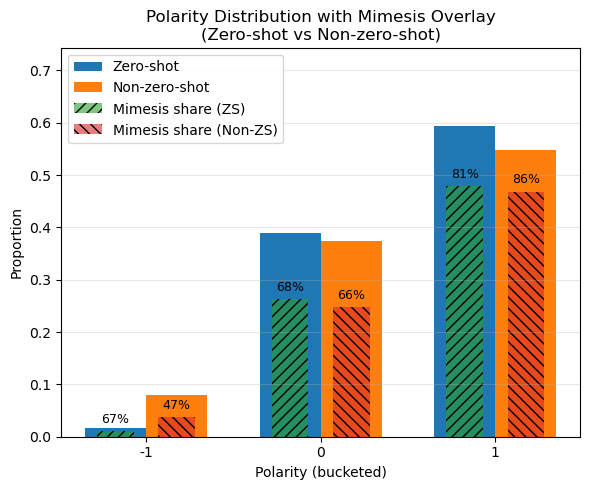

In [10]:
df = pd.read_csv("../data/responses_judged.csv")
print(len(df))
df = df[df["prompt_id"].str.startswith("politics")]
print(len(df))
df = df[(df["iteration"]==0)|(df["context"]=="zero-shot")]
print(len(df))
participants = pd.read_csv("../data/participants.csv")
participants["iteration"] = participants["zero_shot_id"]
df = df.merge(participants[["user_id", "iteration"]], on="iteration", how="left")
print(len(df))
df.loc[df["context"]!="zero-shot", "user_id"] = df.loc[df["context"]!="zero-shot", "context"]
df.loc[df["gpt_judge"].isna(), "gpt_judge"] = 0
df.loc[df["claude_judge"].isna(), "claude_judge"] = 0
df['polarity'] = df[['gpt_judge', 'claude_judge']].mean(axis=1)
df["context"] = (df["context"]!="zero-shot").astype(int)
df = df[["model", "context", "prompt_id", "user_id", "polarity"]]


df2 = pd.read_csv("../data/survey_results.csv")
df2 = df2[df2["task"]=="politics"]
print(len(df2))
df2["user_id"] = df2["participant"]
df2 = df2[["model", "context", "prompt_id", "user_id", "mimesis", "gender", "political_lean"]]
df = df.merge(df2, on=["model", "context", "prompt_id", "user_id"], how="inner")
df["mimesis"] = (df["mimesis"]>=3).astype(int)
df = df[df["model"]=="claude-sonnet-4-20250514"]
#df = df[df["model"]=="gpt-4.1-mini-2025-04-14"]
def bucketize(x):
    if x <= -0.5:
        return -1
    elif x >= 0.5:
        return 1
    else:
        return 0

# --- Build bucketed distributions and mimesis shares ---

# Map context: 0 = zero-shot, 1 = non-zero-shot (from your earlier recoding)
df_b = df.copy()
df_b["bucket"] = df_b["polarity"].apply(bucketize)

# Helper to get (normalized counts, mimesis share) for a given context flag
def distrib_and_mimesis_share(d, ctx_flag):
    dctx = d[d["context"] == ctx_flag]
    # distribution across buckets (normalized to proportions)
    counts = (
        dctx["bucket"].value_counts()
        .reindex([-1, 0, 1], fill_value=0)
        .astype(float)
    )
    counts = counts / counts.sum() if counts.sum() > 0 else counts

    # share of mimesis==1 within each bucket
    share = (
        dctx.groupby("bucket")["mimesis"]
        .mean()
        .reindex([-1, 0, 1], fill_value=0.0)
    )

    return counts, share

counts_zero, share_zero = distrib_and_mimesis_share(df_b, 0)  # zero-shot
counts_non,  share_non  = distrib_and_mimesis_share(df_b, 1)  # non-zero-shot

# --- Plot bars + overlay the mimesis portion inside each bar ---

x = np.array([-1, 0, 1])
width = 0.35

plt.figure(figsize=(6, 5))
# base bars (overall distribution)
bars_zero = plt.bar(x - width/2, counts_zero.values, width, label="Zero-shot")
bars_non  = plt.bar(x + width/2, counts_non.values,  width, label="Non-zero-shot")

# overlay inner bars showing "portion with mimesis"
overlay_zero_heights = (counts_zero.values * share_zero.values)
overlay_non_heights  = (counts_non.values  * share_non.values)

# draw a slightly narrower, hatched bar inside each base bar
plt.bar(x - width/2, overlay_zero_heights, width*0.6, hatch="///", alpha=0.6,
        label="Mimesis share (ZS)")
plt.bar(x + width/2, overlay_non_heights,  width*0.6, hatch="\\\\\\", alpha=0.6,
        label="Mimesis share (Non-ZS)")

# annotate percentages of mimesis on top of the overlay
for xi, h, s in zip(x - width/2, overlay_zero_heights, share_zero.values):
    if h > 0:
        plt.text(xi, h + 0.01, f"{s*100:.0f}%", ha="center", va="bottom", fontsize=9)
for xi, h, s in zip(x + width/2, overlay_non_heights, share_non.values):
    if h > 0:
        plt.text(xi, h + 0.01, f"{s*100:.0f}%", ha="center", va="bottom", fontsize=9)

plt.xticks(x, ["-1", "0", "1"])
plt.xlabel("Polarity (bucketed)")
plt.ylabel("Proportion")
plt.title("Polarity Distribution with Mimesis Overlay\n(Zero-shot vs Non-zero-shot)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.ylim(0, max((counts_zero.max(), counts_non.max())) * 1.25)  # headroom for labels
plt.tight_layout()
plt.show()


7544
3680
1840
1840
760


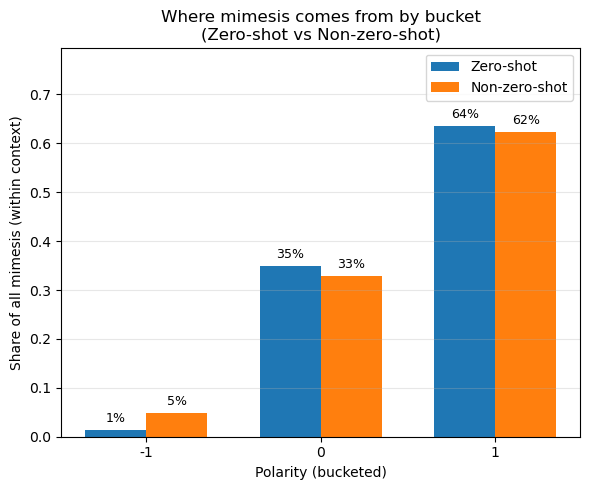

In [47]:
df = pd.read_csv("../data/responses_judged.csv")
print(len(df))
df = df[df["prompt_id"].str.startswith("politics")]
print(len(df))
df = df[(df["iteration"]==0)|(df["context"]=="zero-shot")]
print(len(df))
participants = pd.read_csv("../data/participants.csv")
participants["iteration"] = participants["zero_shot_id"]
df = df.merge(participants[["user_id", "iteration"]], on="iteration", how="left")
print(len(df))
df.loc[df["context"]!="zero-shot", "user_id"] = df.loc[df["context"]!="zero-shot", "context"]
df.loc[df["gpt_judge"].isna(), "gpt_judge"] = 0
df.loc[df["claude_judge"].isna(), "claude_judge"] = 0
df['polarity'] = df[['gpt_judge', 'claude_judge']].mean(axis=1)
df["context"] = (df["context"]!="zero-shot").astype(int)
df = df[["model", "context", "prompt_id", "user_id", "polarity"]]


df2 = pd.read_csv("../data/survey_results.csv")
df2 = df2[df2["task"]=="politics"]
print(len(df2))
df2["user_id"] = df2["participant"]
df2 = df2[["model", "context", "prompt_id", "user_id", "mimesis", "gender", "political_lean"]]
df = df.merge(df2, on=["model", "context", "prompt_id", "user_id"], how="inner")
df["mimesis"] = (df["mimesis"]>=3).astype(int)
df = df[df["model"]=="claude-sonnet-4-20250514"]
#df = df[df["model"]=="gpt-4.1-mini-2025-04-14"]
def bucketize(x):
    if x <= -0.5:
        return -1
    elif x >= 0.5:
        return 1
    else:
        return 0

# --- Build bucketed distributions and mimesis composition-by-bucket ---

import numpy as np
import matplotlib.pyplot as plt

df_b = df.copy()
df_b["bucket"] = df_b["polarity"].apply(bucketize)

def mimesis_composition_by_bucket(d, ctx_flag):
    dctx = d[d["context"] == ctx_flag]
    # count how many MIMESIS==1 items fall into each bucket
    counts_mimesis = (
        dctx[dctx["mimesis"] == 1]["bucket"]
        .value_counts()
        .reindex([-1, 0, 1], fill_value=0)
        .astype(float)
    )
    total_mimesis = counts_mimesis.sum()
    # proportion of all mimesis (in this context) that comes from each bucket
    props = counts_mimesis / total_mimesis if total_mimesis > 0 else counts_mimesis
    return counts_mimesis, props

counts_mim_zero, props_zero = mimesis_composition_by_bucket(df_b, 0)  # zero-shot
counts_mim_non,  props_non  = mimesis_composition_by_bucket(df_b, 1)  # non-zero-shot

# --- Plot: for each bucket, show the share of all mimesis that comes from it ---

x = np.array([-1, 0, 1])
width = 0.35

plt.figure(figsize=(6, 5))
bars_zero = plt.bar(x - width/2, props_zero.values, width, label="Zero-shot")
bars_non  = plt.bar(x + width/2, props_non.values,  width, label="Non-zero-shot")

# annotate percentages
for xi, h in zip(x - width/2, props_zero.values):
    if h > 0:
        plt.text(xi, h + 0.01, f"{h*100:.0f}%", ha="center", va="bottom", fontsize=9)
for xi, h in zip(x + width/2, props_non.values):
    if h > 0:
        plt.text(xi, h + 0.01, f"{h*100:.0f}%", ha="center", va="bottom", fontsize=9)

plt.xticks(x, ["-1", "0", "1"])
plt.xlabel("Polarity (bucketed)")
plt.ylabel("Share of all mimesis (within context)")
plt.title("Where mimesis comes from by bucket\n(Zero-shot vs Non-zero-shot)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.ylim(0, max((props_zero.max(), props_non.max())) * 1.25 if (props_zero.max() or props_non.max()) else 1.0)
plt.tight_layout()
plt.show()


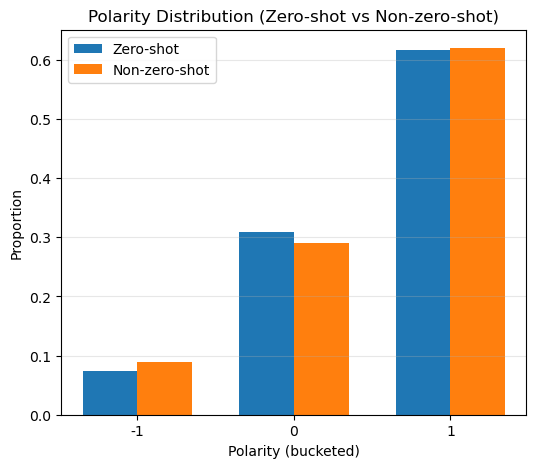

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("../data/responses_judged.csv")
df = df[df["prompt_id"].str.startswith("politics")]
df["user_id"] = df["context"]
df.loc[df["gpt_judge"].isna(), "gpt_judge"] = 0
df.loc[df["claude_judge"].isna(), "claude_judge"] = 0
df['polarity'] = df[['gpt_judge', 'claude_judge']].mean(axis=1)
df["polarity"].value_counts()
# Define bucketing function
def bucketize(x):
    if x <= -0.5:
        return -1
    elif x >= 0.5:
        return 1
    else:
        return 0

# Apply bucketing
df = df[df["model"]=="gpt-4.1-mini-2025-04-14"]
zero_shot = df.loc[df["context"]=="zero-shot", "polarity"].apply(bucketize)
non_zero = df.loc[df["context"]!="zero-shot", "polarity"].apply(bucketize)

# Count frequencies
counts_zero = zero_shot.value_counts().reindex([-1, 0, 1], fill_value=0)
counts_non = non_zero.value_counts().reindex([-1, 0, 1], fill_value=0)

# Normalize to proportions (optional, remove if you want raw counts)
counts_zero = counts_zero / counts_zero.sum()
counts_non = counts_non / counts_non.sum()

# Plot
x = np.array([-1, 0, 1])
width = 0.35

plt.figure(figsize=(6, 5))
plt.bar(x - width/2, counts_zero, width, label="Zero-shot")
plt.bar(x + width/2, counts_non, width, label="Non-zero-shot")

plt.xticks(x, ["-1", "0", "1"])
plt.xlabel("Polarity (bucketed)")
plt.ylabel("Proportion")
plt.title("Polarity Distribution (Zero-shot vs Non-zero-shot)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()


In [21]:
df = pd.read_csv("../data/responses_judged.csv")

df["model"].unique()

array(['claude-sonnet-4-20250514', 'gpt-4.1-mini-2025-04-14'],
      dtype=object)

7544
3680
1840
1840
760


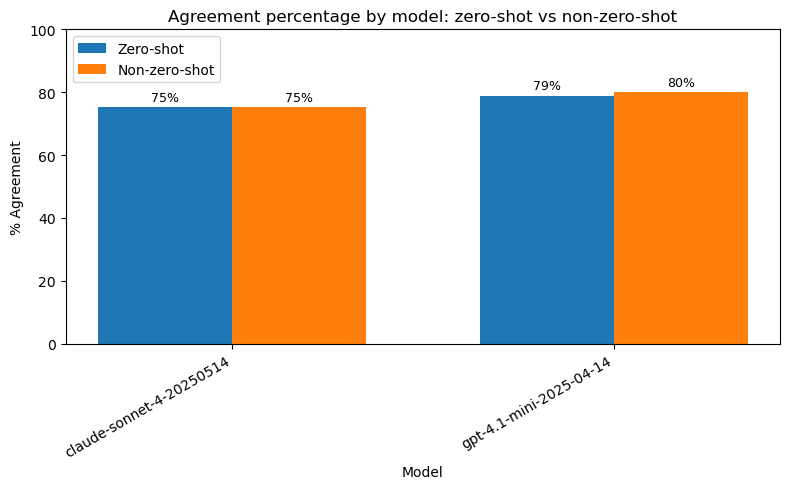

In [54]:
df = pd.read_csv("../data/responses_judged.csv")
print(len(df))
df = df[df["prompt_id"].str.startswith("politics")]
print(len(df))
df = df[(df["iteration"]==0)|(df["context"]=="zero-shot")]
print(len(df))
participants = pd.read_csv("../data/participants.csv")
participants["iteration"] = participants["zero_shot_id"]
df = df.merge(participants[["user_id", "iteration"]], on="iteration", how="left")
print(len(df))
df.loc[df["context"]!="zero-shot", "user_id"] = df.loc[df["context"]!="zero-shot", "context"]
df.loc[df["gpt_judge"].isna(), "gpt_judge"] = 0
df.loc[df["claude_judge"].isna(), "claude_judge"] = 0
df['polarity'] = df[['gpt_judge', 'claude_judge']].mean(axis=1)
df["context"] = (df["context"]!="zero-shot").astype(int)
df = df[["model", "context", "prompt_id", "user_id", "polarity"]]


df2 = pd.read_csv("../data/survey_results.csv")
df2 = df2[df2["task"]=="politics"]
print(len(df2))
df2["user_id"] = df2["participant"]
df2 = df2[["model", "context", "prompt_id", "user_id", "mimesis", "gender", "political_lean"]]
df = df.merge(df2, on=["model", "context", "prompt_id", "user_id"], how="inner")
df["mimesis"] = (df["mimesis"]>=3).astype(int)

df["political_lean"] = df["political_lean"].map({
    "Very Liberal": 1,
    "Liberal": 0.5,
    "Moderate": 0,
    "Conservative": -0.5,
    "Very Conservative": -1.0})

def bucketize(x):
    if x <= -0.5:
        return -1
    elif x >= 0.5:
        return 1
    else:
        return 0

df["polarity"] = df["polarity"].apply(bucketize)
df["political_lean"] = df["political_lean"].apply(bucketize)
df["agreement"] = (df["polarity"]==df["political_lean"]).astype(int)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assumes your 'df' already exists as prepared above

# Compute % agreement per (model, context)
agg = (
    df.groupby(["model", "context"])["mimesis"]
      .mean()
      .mul(100)
      .rename("% Agreement")
      .reset_index()
)

# Pivot for plotting
pivot = agg.pivot(index="model", columns="context", values="% Agreement").fillna(0)

# Ensure consistent column ordering (0 = zero-shot, 1 = non-zero-shot)
pivot = pivot[[0, 1]] if set([0,1]).issubset(pivot.columns) else pivot

# Plot grouped bars
x = np.arange(len(pivot))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars0 = ax.bar(x - width/2, pivot[0].values, width, label="Zero-shot")
bars1 = ax.bar(x + width/2, pivot[1].values, width, label="Non-zero-shot")

ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=30, ha="right")
ax.set_ylim(0, 100)
ax.set_ylabel("% Agreement")
ax.set_xlabel("Model")
ax.set_title("Agreement percentage by model: zero-shot vs non-zero-shot")
ax.legend()

# Add value labels
for bars in [bars0, bars1]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                f"{height:.0f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

